In [1]:
import subprocess
import shlex
import re
import json

import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats

from IPython.display import display, Markdown

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")
TIMING_PATTERN = re.compile(r"\((\d+(?:\.\d+)?)s\)")

In [4]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [5]:
subprocess.run(shlex.split("cargo build --release"), check=True);

CompletedProcess(args=['cargo', 'build', '--release'], returncode=0)

In [6]:
def test_exponential_inter_event_timing(
    mode, delta_t=1.0, lamda=0.5, seeds=[42], limit=10000000000, flags=[],
):
    factor = np.sqrt(10 ** abs(np.log10(lamda * delta_t)))
    
    scaled_limit = int(limit / factor)
    
    timings = []
    
    for seed in seeds:
        output = subprocess.run(shlex.split(
            f"{target_directory}/release/analysis-performance-exponential --delta-t {delta_t} --seed {seed} " +
            f"--lambda {lamda} --limit {scaled_limit} {' '.join(f'--{f}' for f in flags)} {CC_PATTERN.sub('-', mode).lower()}"
        ), check=True, capture_output=True, text=True).stdout
        
        timings.append(float(TIMING_PATTERN.search(output).group(1)) / scaled_limit)
    
    return timings

In [7]:
display(Markdown("# GPU Information:"))

display(Markdown('>```\n' + subprocess.run(
    shlex.split("nvidia-smi"), check=True, capture_output=True, text=True
).stdout.replace('\n', '\n>') + '```'))

# GPU Information:

>```
Sun May 23 20:12:06 2021       
>+-----------------------------------------------------------------------------+
>| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
>|-------------------------------+----------------------+----------------------+
>| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
>| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
>|                               |                      |               MIG M. |
>|===============================+======================+======================|
>|   0  Quadro K620         On   | 00000000:02:00.0 Off |                  N/A |
>| 34%   38C    P8     1W /  30W |    270MiB /  2000MiB |      0%      Default |
>|                               |                      |                  N/A |
>+-------------------------------+----------------------+----------------------+
>                                                                               
>+-----------------------------------------------------------------------------+
>| Processes:                                                                  |
>|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
>|        ID   ID                                                   Usage      |
>|=============================================================================|
>|    0   N/A  N/A      1628      G   /usr/lib/xorg/Xorg                 31MiB |
>|    0   N/A  N/A      1752      G   /usr/bin/gnome-shell               52MiB |
>|    0   N/A  N/A      2238      G   /usr/lib/xorg/Xorg                148MiB |
>|    0   N/A  N/A      2406      G   /usr/bin/gnome-shell               18MiB |
>|    0   N/A  N/A      3096      G   ...gAAAAAAAAA --shared-files       10MiB |
>+-----------------------------------------------------------------------------+
>```

In [8]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0,
]

seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

# Different limits to account for GPU timeouts
def limit_for_lambda(lamda):
    if lamda < 1.0:
        return 3162
    
    if lamda <= 100:
        return 10000
    
    return 50000

exp_times = [
    test_exponential_inter_event_timing("Exponential", lamda=lamda, seeds=seeds, limit=limit_for_lambda(lamda), flags=["cuda"])
    for lamda in lambdas
]

# Different limits to account for GPU timeouts
def limit_for_lambda(lamda):
    if lamda <= 100:
        return 7500
    
    return 2500

poi_times = [
    test_exponential_inter_event_timing("Poisson", lamda=lamda, seeds=seeds, limit=limit_for_lambda(lamda), flags=["cuda"])
    for lamda in lambdas
]

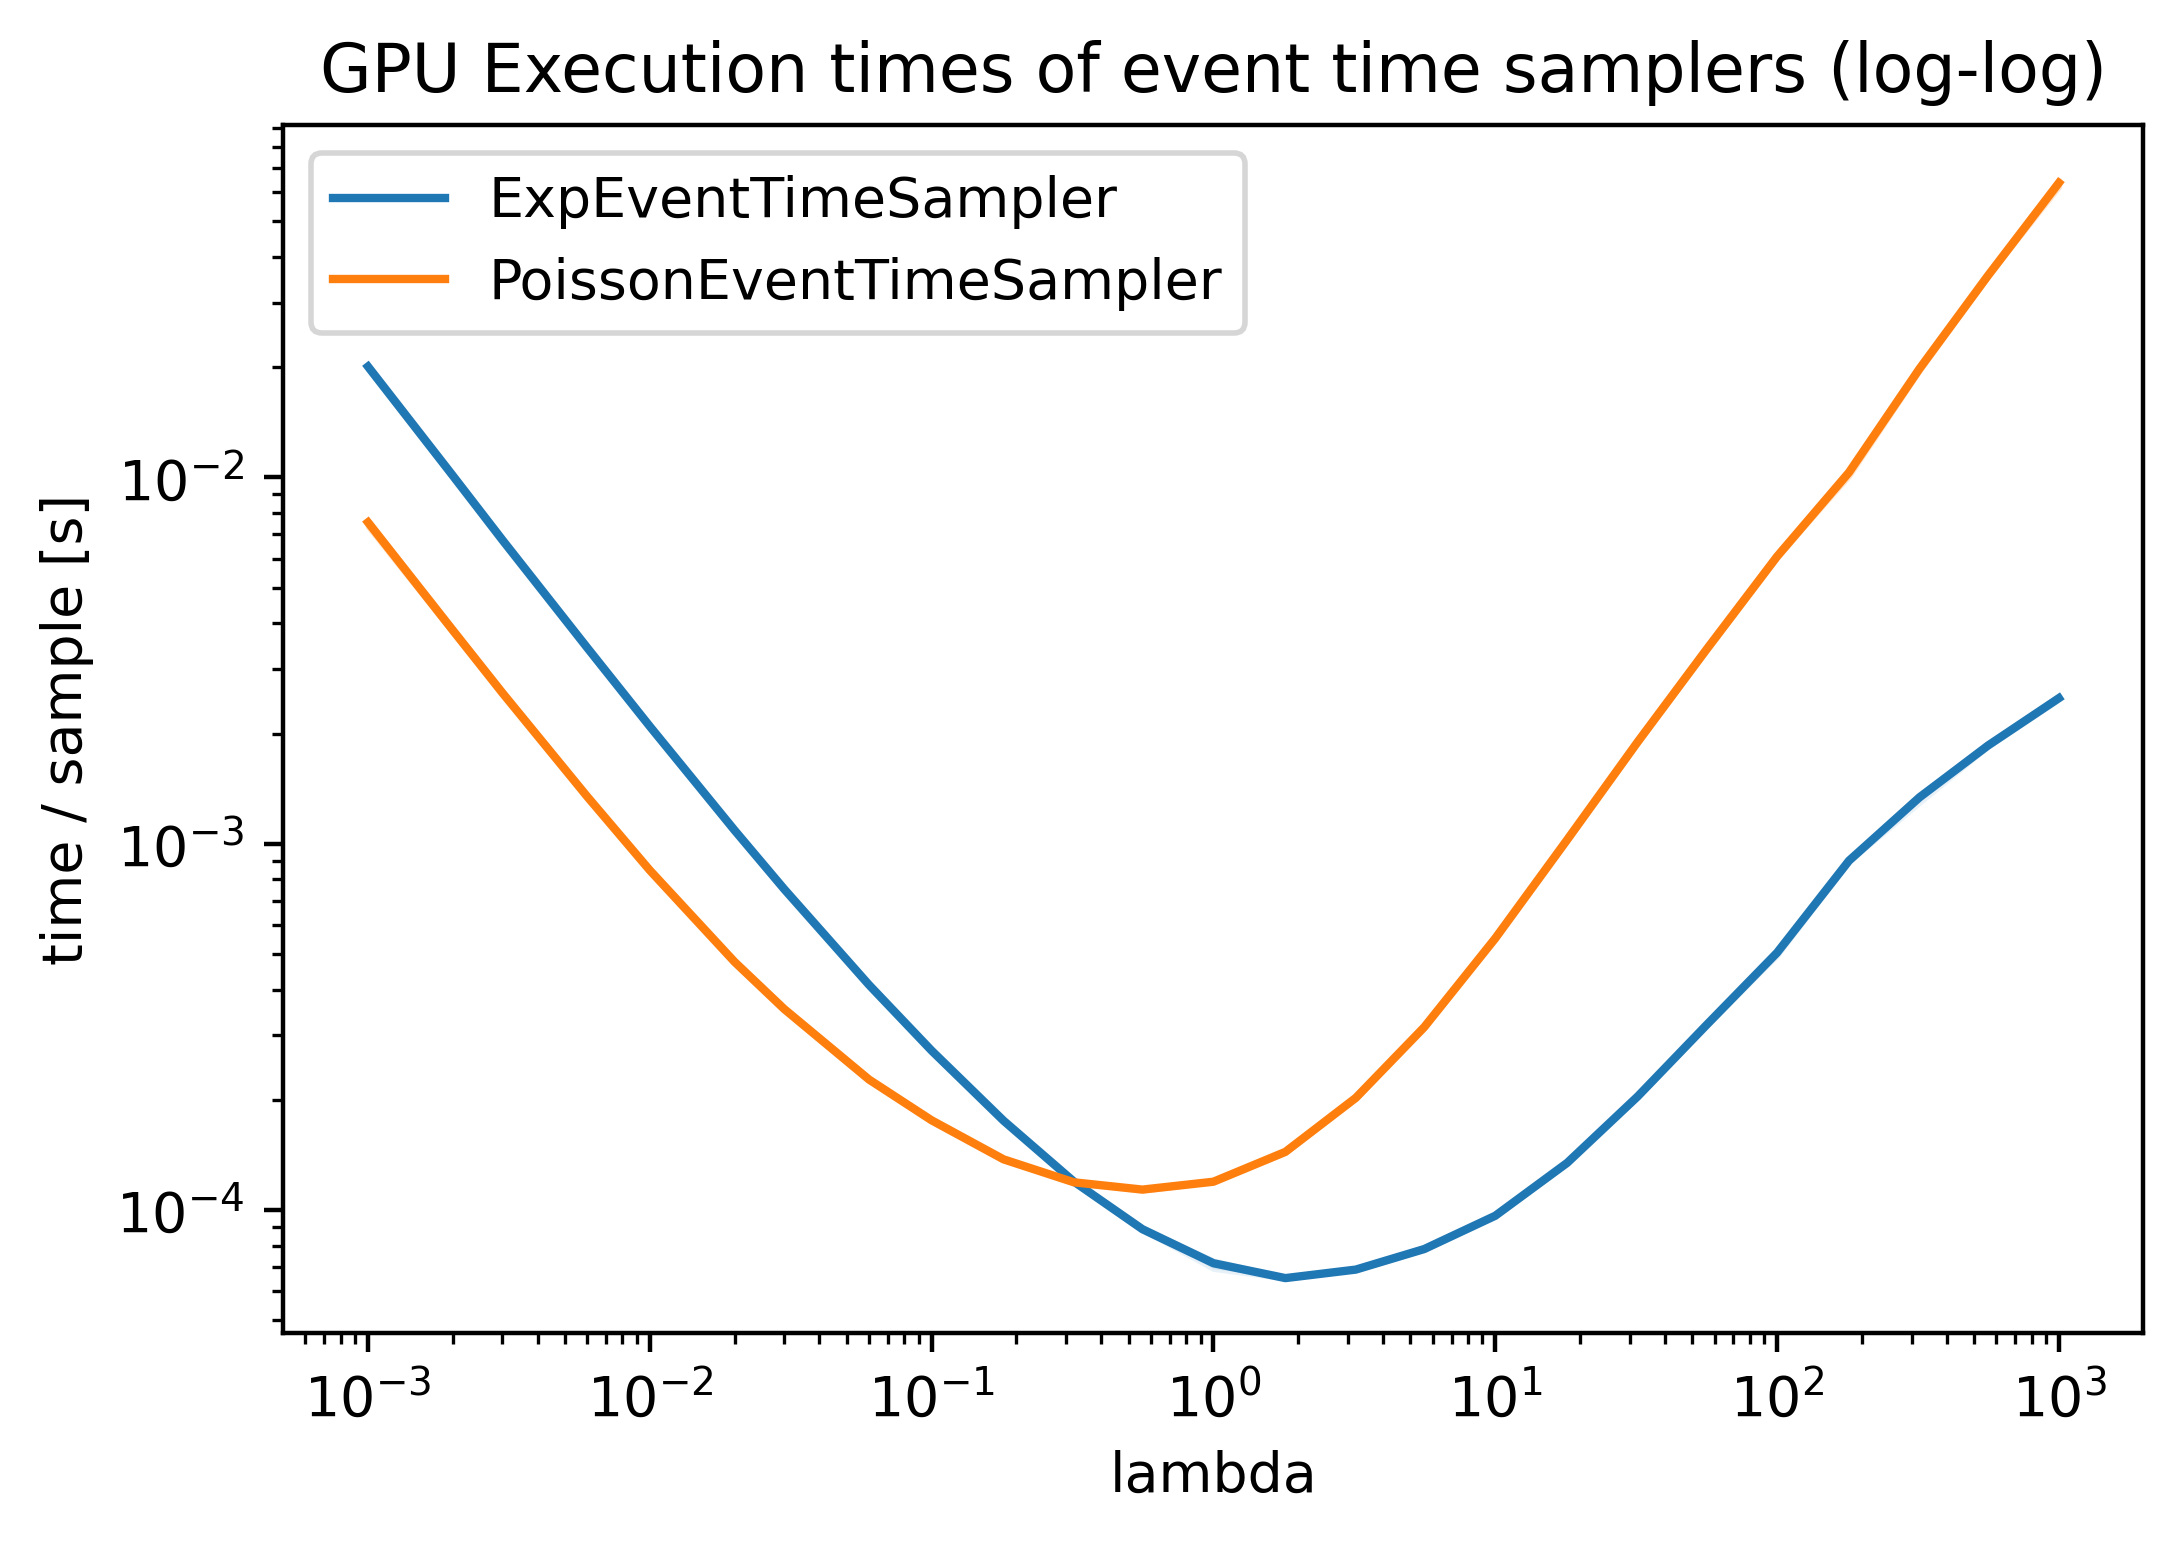

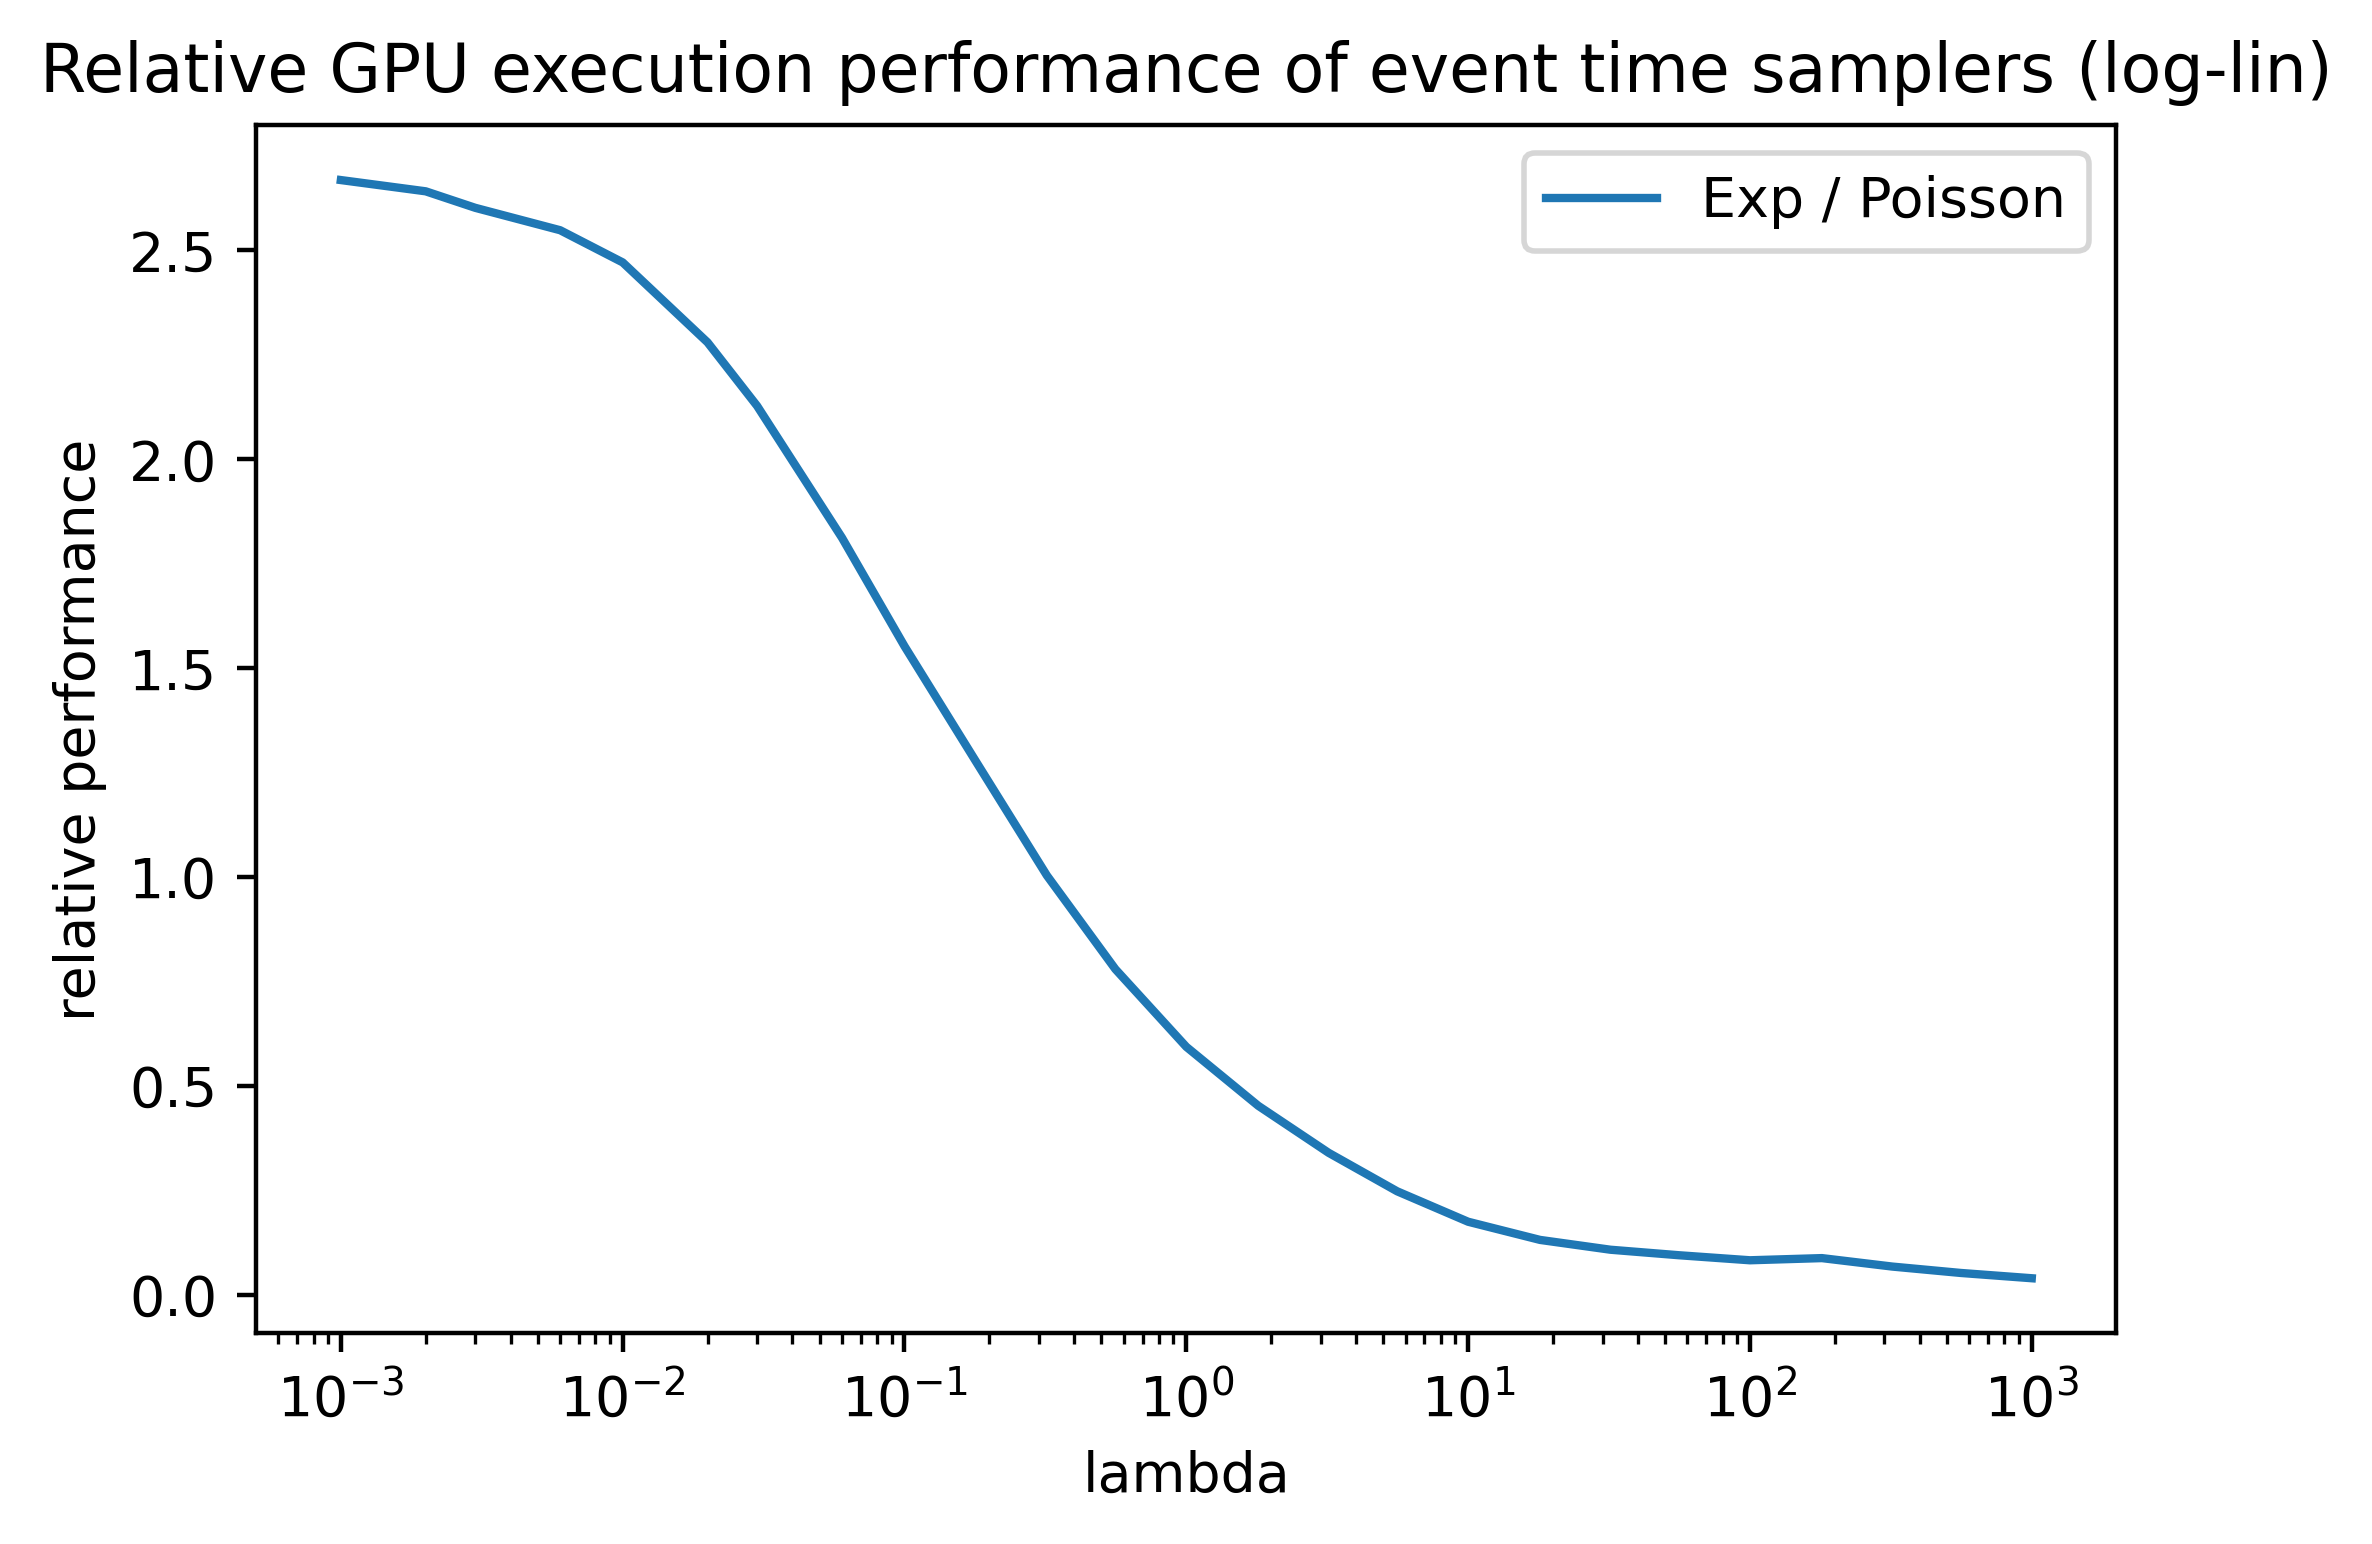

In [9]:
plt.title("GPU Execution times of event time samplers (log-log)")
plt.xlabel("lambda")
plt.ylabel("time / sample [s]")
plt.xscale("log")
plt.yscale("log")

plt.plot(lambdas, np.median(exp_times, axis=1), label="ExpEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(exp_times, axis=1) - np.std(exp_times, axis=1),
    np.mean(exp_times, axis=1) + np.std(exp_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.1
)
plt.plot(lambdas, np.median(poi_times, axis=1), label="PoissonEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(poi_times, axis=1) - np.std(poi_times, axis=1),
    np.mean(poi_times, axis=1) + np.std(poi_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.2
)
plt.legend()
plt.show()

plt.title("Relative GPU execution performance of event time samplers (log-lin)")
plt.xlabel("lambda")
plt.ylabel("relative performance")
plt.xscale("log")
plt.plot(lambdas, [e / p for e, p in zip(np.mean(exp_times, axis=1), np.mean(poi_times, axis=1))], label="Exp / Poisson")
plt.legend()
plt.show()

In [10]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0, 1800, 3200, 5600, 10000,
]

seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

exp_times = [
    test_exponential_inter_event_timing("Exponential", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]
poi_times = [
    test_exponential_inter_event_timing("Poisson", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]

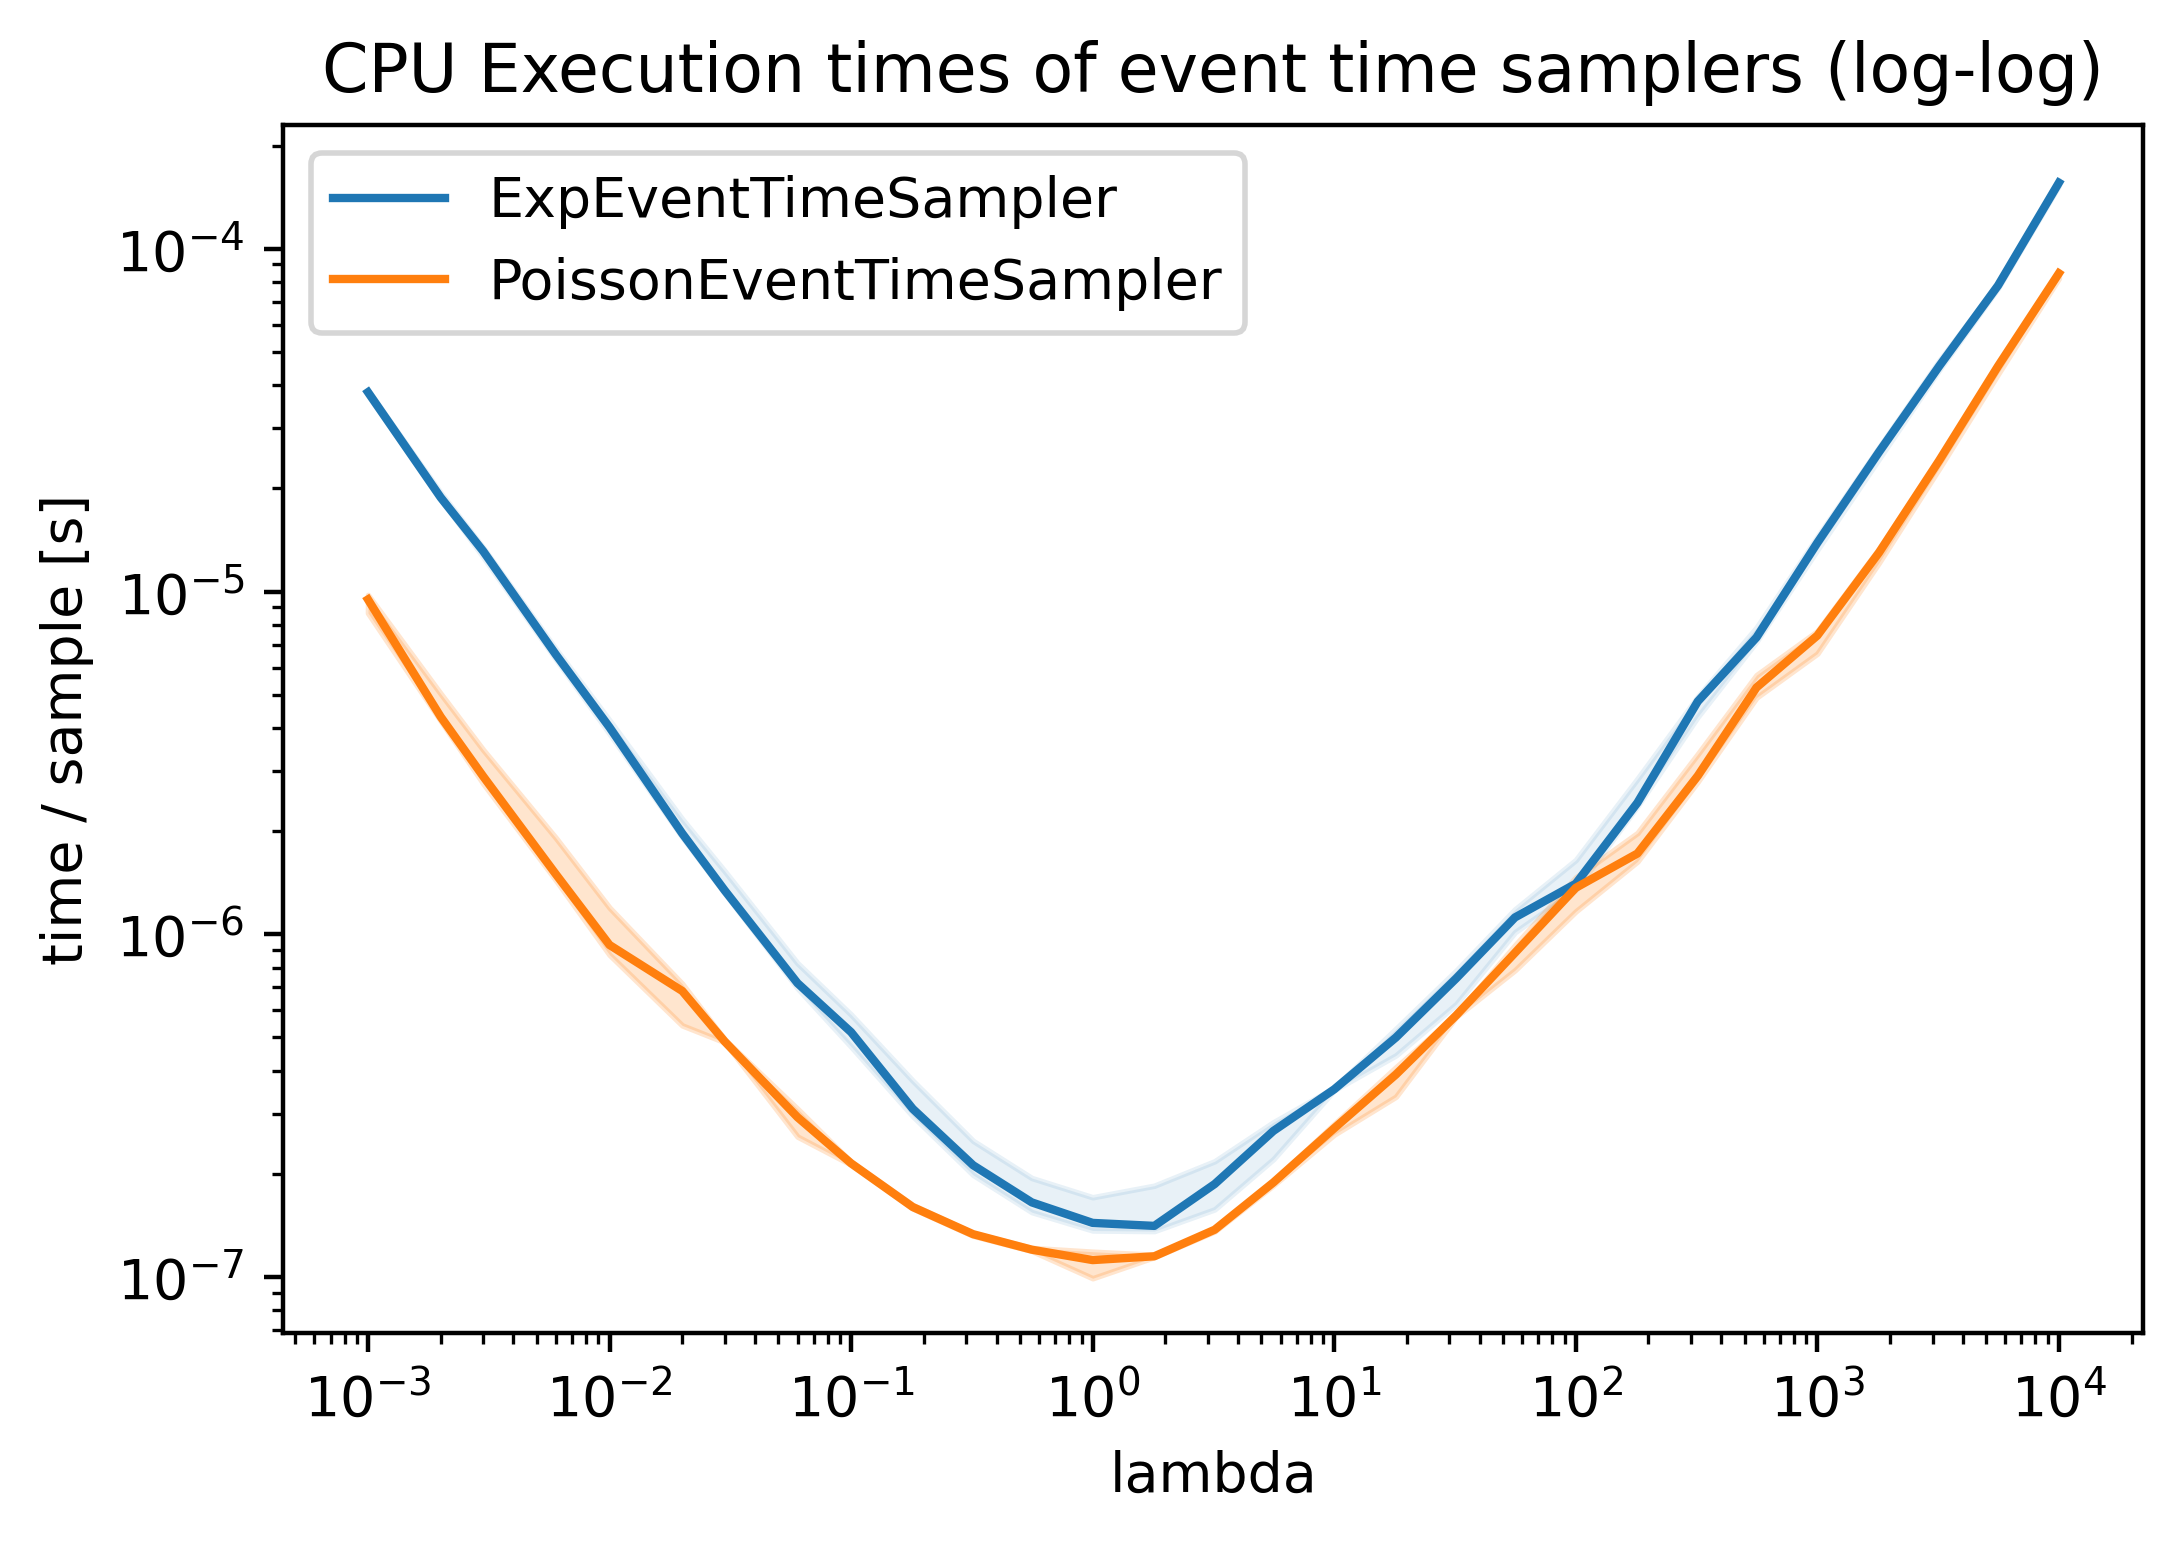

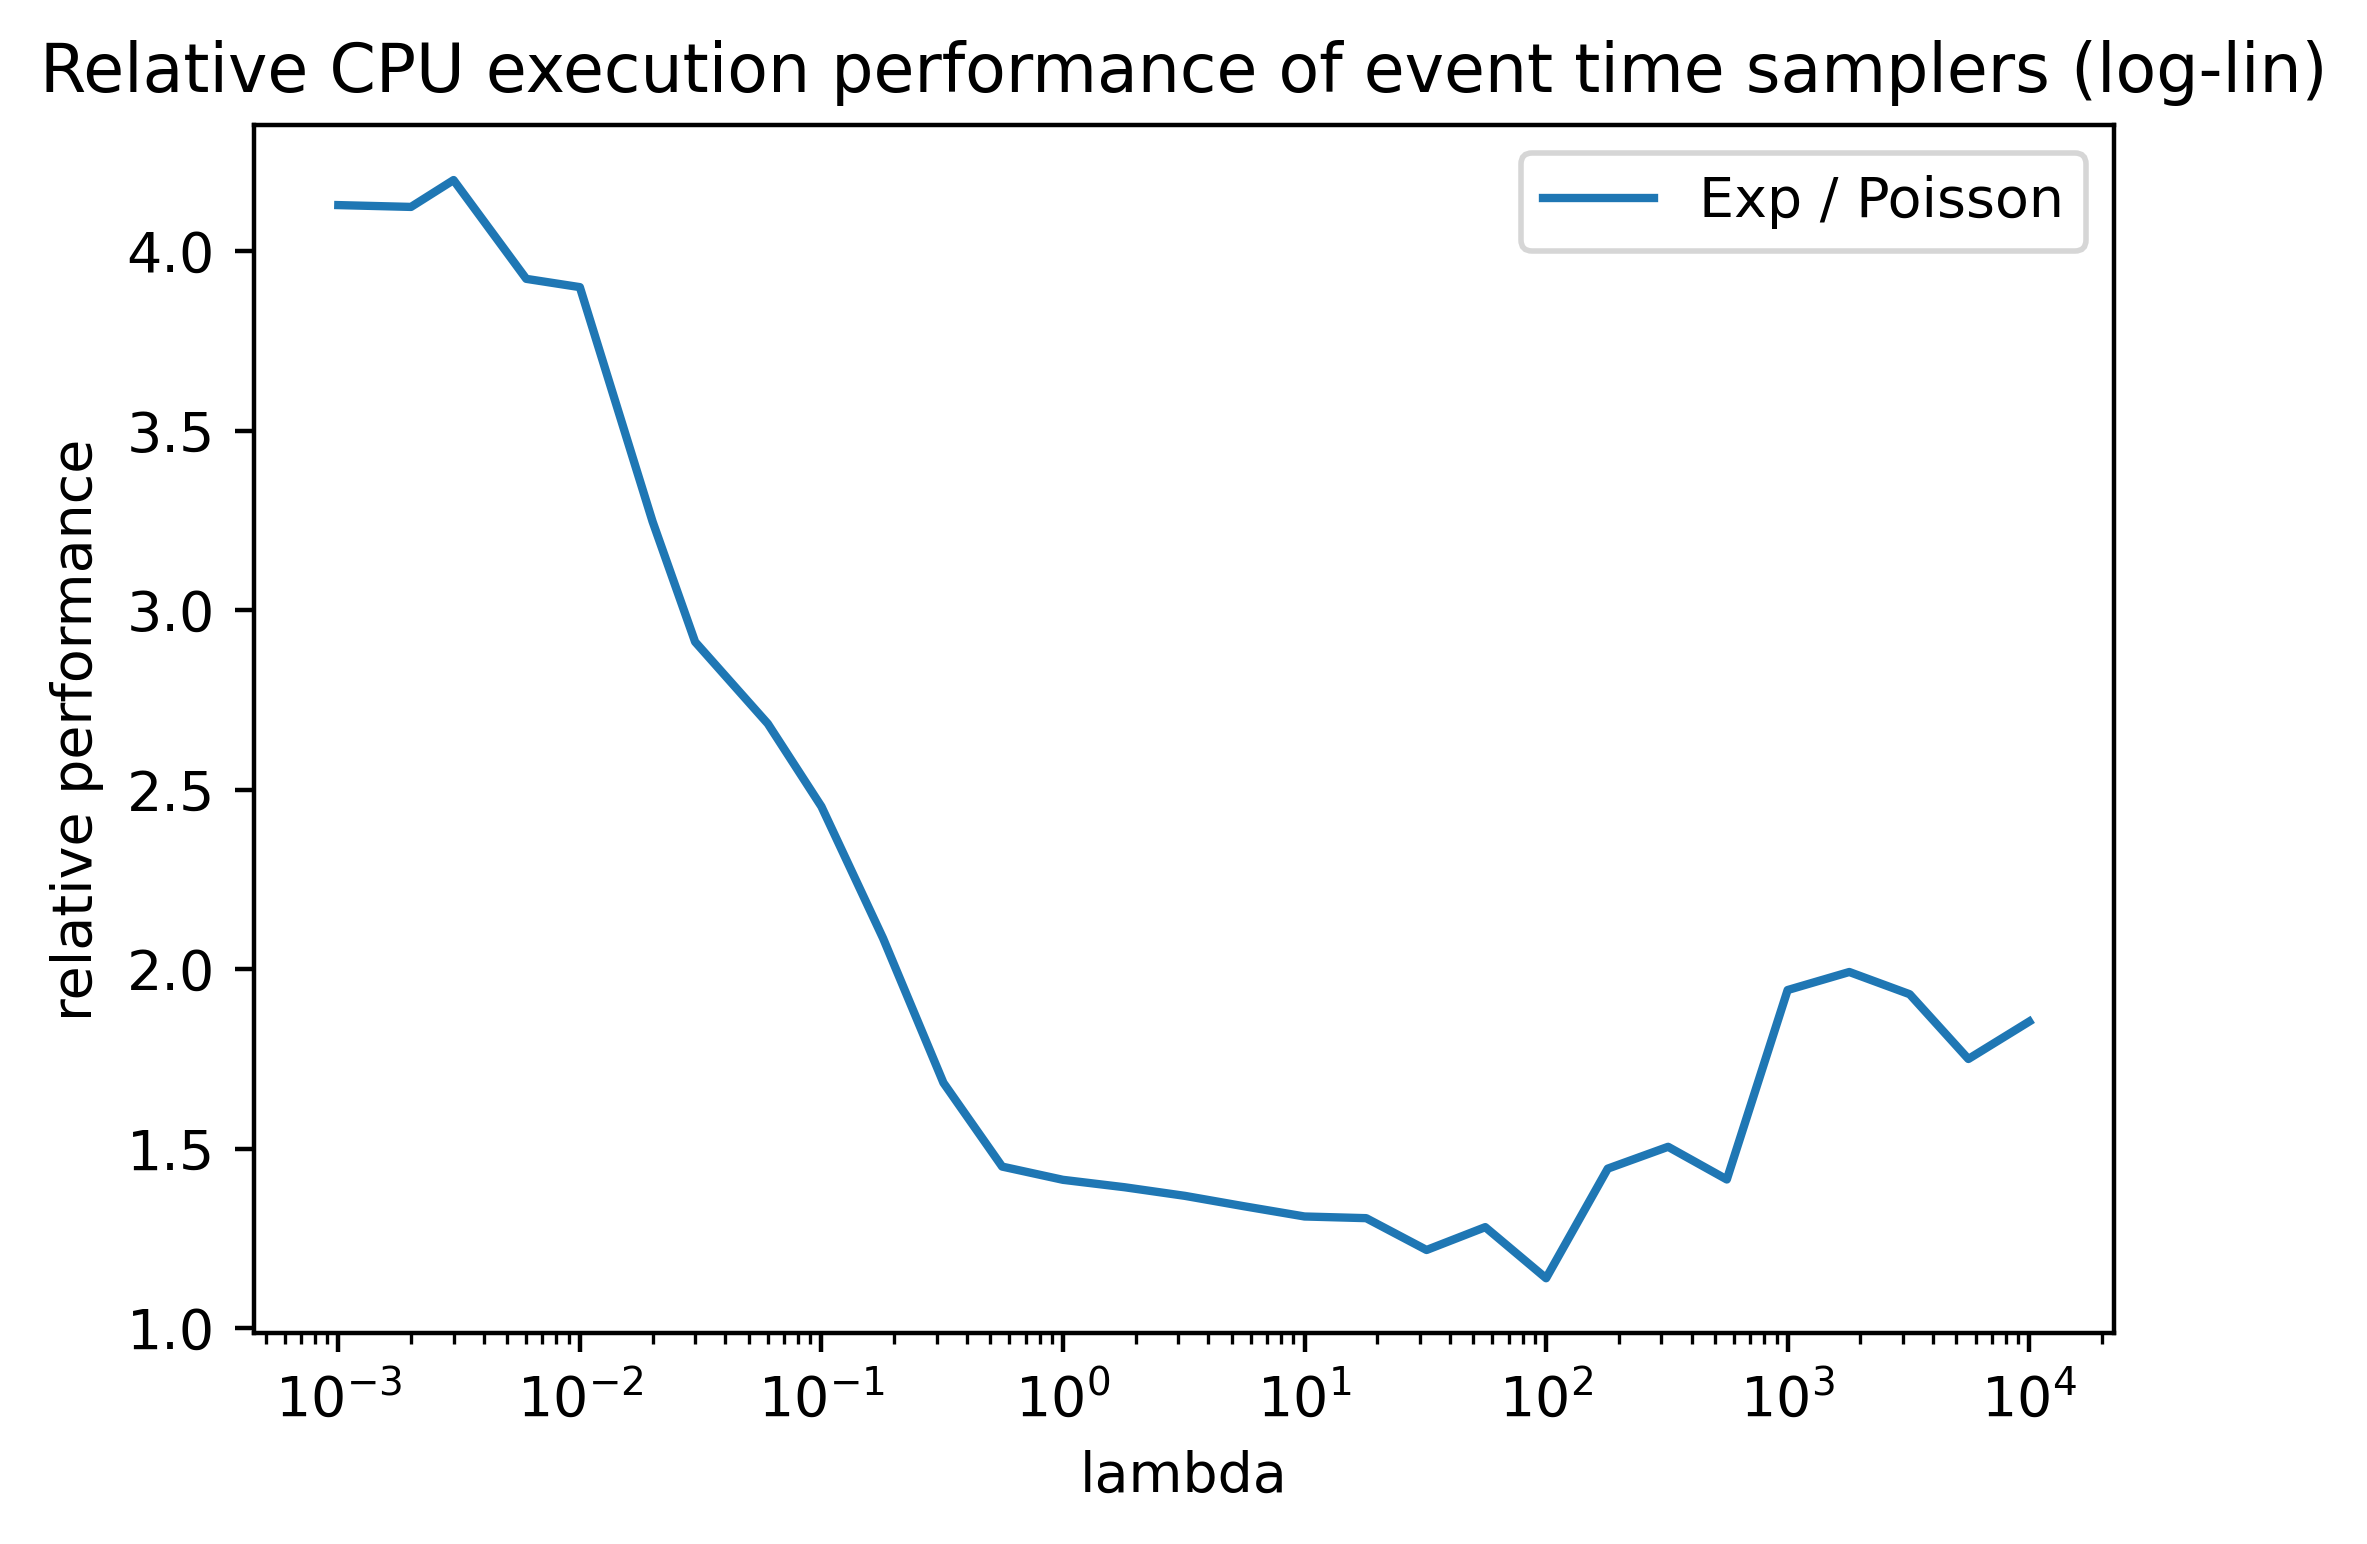

In [11]:
plt.title("CPU Execution times of event time samplers (log-log)")
plt.xlabel("lambda")
plt.ylabel("time / sample [s]")
plt.xscale("log")
plt.yscale("log")

plt.plot(lambdas, np.median(exp_times, axis=1), label="ExpEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(exp_times, axis=1) - np.std(exp_times, axis=1),
    np.mean(exp_times, axis=1) + np.std(exp_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.1
)
plt.plot(lambdas, np.median(poi_times, axis=1), label="PoissonEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(poi_times, axis=1) - np.std(poi_times, axis=1),
    np.mean(poi_times, axis=1) + np.std(poi_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.2
)
plt.legend()
plt.show()

plt.title("Relative CPU execution performance of event time samplers (log-lin)")
plt.xlabel("lambda")
plt.ylabel("relative performance")
plt.xscale("log")
plt.plot(lambdas, [e / p for e, p in zip(np.mean(exp_times, axis=1), np.mean(poi_times, axis=1))], label="Exp / Poisson")
plt.legend()
plt.show()